In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os
from dateutil.relativedelta import relativedelta
import scipy.stats as stats
import math
import textwrap

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
import pylab
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score


In [186]:
inpatient=pd.read_csv("Medicare_Provider_Charge_Inpatient_DRG100_FY2011.csv")
outpatient=pd.read_csv("Medicare_Provider_Charge_Outpatient_APC30_CY2011_v2.csv")

In [134]:
inpatient.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07692,5777.241758,4763.736264
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85714,5787.571429,4976.714286
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37500,5434.958333,4453.791667
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28000,5417.560000,4129.160000
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27778,5658.333333,4851.444444


In [4]:
outpatient.head()

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
0,0012 - Level I Debridement & Destruction,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,23,78.086957,21.910435
1,0012 - Level I Debridement & Destruction,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,AK - Anchorage,994,149.589749,36.623853
2,0012 - Level I Debridement & Destruction,30064,"UNIVERSITY OF ARIZONA MEDICAL CTR-UNIVERSIT, THE",1501 NORTH CAMPBELL AVENUE,TUCSON,AZ,85724,AZ - Tucson,1765,50.135411,14.541841
3,0012 - Level I Debridement & Destruction,30088,BANNER BAYWOOD MEDICAL CENTER,6644 EAST BAYWOOD AVENUE,MESA,AZ,85206,AZ - Mesa,20,112.400000,23.736000
4,0012 - Level I Debridement & Destruction,30111,"UNIVERSITY OF ARIZONA MEDICAL CTR- SOUTH CAM, THE",2800 EAST AJO WAY,TUCSON,AZ,85713,AZ - Tucson,22,152.045455,16.569091


In [135]:
print(inpatient.shape)
print(outpatient.shape)

(163065, 12)
(43372, 11)


## Part 1: Identify providers that overcharge for certain procedures or regions where procedures are too expensive.
### Part 1: A & B:- Highest Cost Variation for a Procedure by Provider

**For Inpatients**

In [136]:
# Checking if we have multiple entries for a provider and Procedure
(inpatient.groupby(["DRG Definition","Provider Id"])["Average Medicare Payments"].count()>1).unique()

array([False])

Since we don't have multiple entries of provider against a procedure, the `"Average Medicare Payments"` is indeed mean of the payment done to that provider for given procedure.<br><br>
So, we will use the field to determine highest cost variation for a procedure (max val - min val)

In [163]:
max_d = inpatient.groupby(["DRG Definition"])["Average Medicare Payments"].max().reset_index()
max_d.rename(columns={"Average Medicare Payments":"max_med_pay"},inplace=True)
min_d = inpatient.groupby(["DRG Definition"])["Average Medicare Payments"].min().reset_index()
min_d.rename(columns={"Average Medicare Payments":"min_med_pay"},inplace=True)

In [138]:
print(max_d.shape)
print(min_d.shape)

(100, 2)
(100, 2)


In [164]:
procedure = pd.merge(max_d,min_d,on=["DRG Definition"],how='inner')
procedure

,DRG Definition,max_med_pay,min_med_pay
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,15855.181820,3592.857143
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,22873.493980,3116.428571
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,48632.281250,6603.636364
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,23402.263160,4109.250000
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,13710.235290,2771.882353
5,069 - TRANSIENT ISCHEMIA,9959.588235,2348.071429
6,074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O...,13310.285710,2456.833333
7,101 - SEIZURES W/O MCC,13961.181820,2629.692308
8,149 - DYSEQUILIBRIUM,8615.315789,2012.352941
9,176 - PULMONARY EMBOLISM W/O MCC,15161.277780,3561.687500


In [165]:
procedure["variation"] = procedure.max_med_pay - procedure.min_med_pay
procedure.head()

,DRG Definition,max_med_pay,min_med_pay,variation
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,15855.18182,3592.857143,12262.324677
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,22873.49398,3116.428571,19757.065409
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,48632.28125,6603.636364,42028.644886
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,23402.26316,4109.250000,19293.013160
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,13710.23529,2771.882353,10938.352937


In [166]:
# We will concentrate on the first five procedures with the highest variance
procedure = procedure.sort_values(['variation'], ascending=[0])
procedure.head()

,DRG Definition,max_med_pay,min_med_pay,variation
21,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,154620.81820,18375.000000,136245.818200
66,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,130466.57140,8993.916667,121472.654733
91,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,133177.26670,19463.333330,113713.933370
92,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,109303.21430,19673.714290,89629.500010
67,469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,99114.86667,11835.400000,87279.466670


In [167]:
top_proc = procedure["DRG Definition"].head().to_list()
top_proc

['207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS',
 '460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC',
 '853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC',
 '870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS',
 '469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W MCC']

In [168]:
subset = inpatient[inpatient["DRG Definition"].isin(top_proc)].copy()
subset = pd.merge(subset,procedure,on=["DRG Definition"],how='left')
subset

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,max_med_pay,min_med_pay,variation
0,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,19,107347.52630,28246.68421,27831.31579,154620.8182,18375.00000,136245.81820
1,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,12,117772.91670,27573.41667,26638.08333,154620.8182,18375.00000,136245.81820
2,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,15,121698.53330,35806.53333,29393.46667,154620.8182,18375.00000,136245.81820
3,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,21,117604.23810,34607.95238,32496.47619,154620.8182,18375.00000,136245.81820
4,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10024,JACKSON HOSPITAL & CLINIC INC,1725 PINE STREET,MONTGOMERY,AL,36106,AL - Montgomery,19,89957.00000,27953.78947,27180.94737,154620.8182,18375.00000,136245.81820
5,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,15,65345.33333,29752.66667,28403.66667,154620.8182,18375.00000,136245.81820
6,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,28,188031.14290,42550.21429,40777.57143,154620.8182,18375.00000,136245.81820
7,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,AL - Huntsville,78,145193.93590,32294.03846,30855.15385,154620.8182,18375.00000,136245.81820
8,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10040,GADSDEN REGIONAL MEDICAL CENTER,1007 GOODYEAR AVENUE,GADSDEN,AL,35903,AL - Birmingham,20,236092.75000,27311.40000,25758.85000,154620.8182,18375.00000,136245.81820
9,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10046,RIVERVIEW REGIONAL MEDICAL CENTER,600 SOUTH THIRD STREET,GADSDEN,AL,35901,AL - Birmingham,12,252726.25000,32591.33333,27020.25000,154620.8182,18375.00000,136245.81820


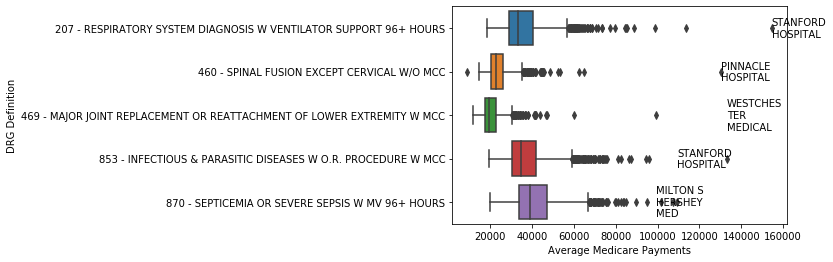

<Figure size 3600x3600 with 0 Axes>

In [169]:
boxplot = sns.boxplot(x=subset["Average Medicare Payments"],y=subset["DRG Definition"])

for row in subset.itertuples():
    provider = row[3][:20]
    proc = row[1]
    top_proc = {i:top_proc[i]for i in range(0,len(top_proc))}
    for x in top_proc.items():
        if x[1] ==proc:
            y_axis = x[0]
    val = row[12]
    # Check if payment is the max for the procedure, then print the label
    if val == row[13]:
        plt.text(val, y_axis, textwrap.fill(provider,8), ha='left', va='center')

plt.figure(figsize=(50,50))
plt.show()

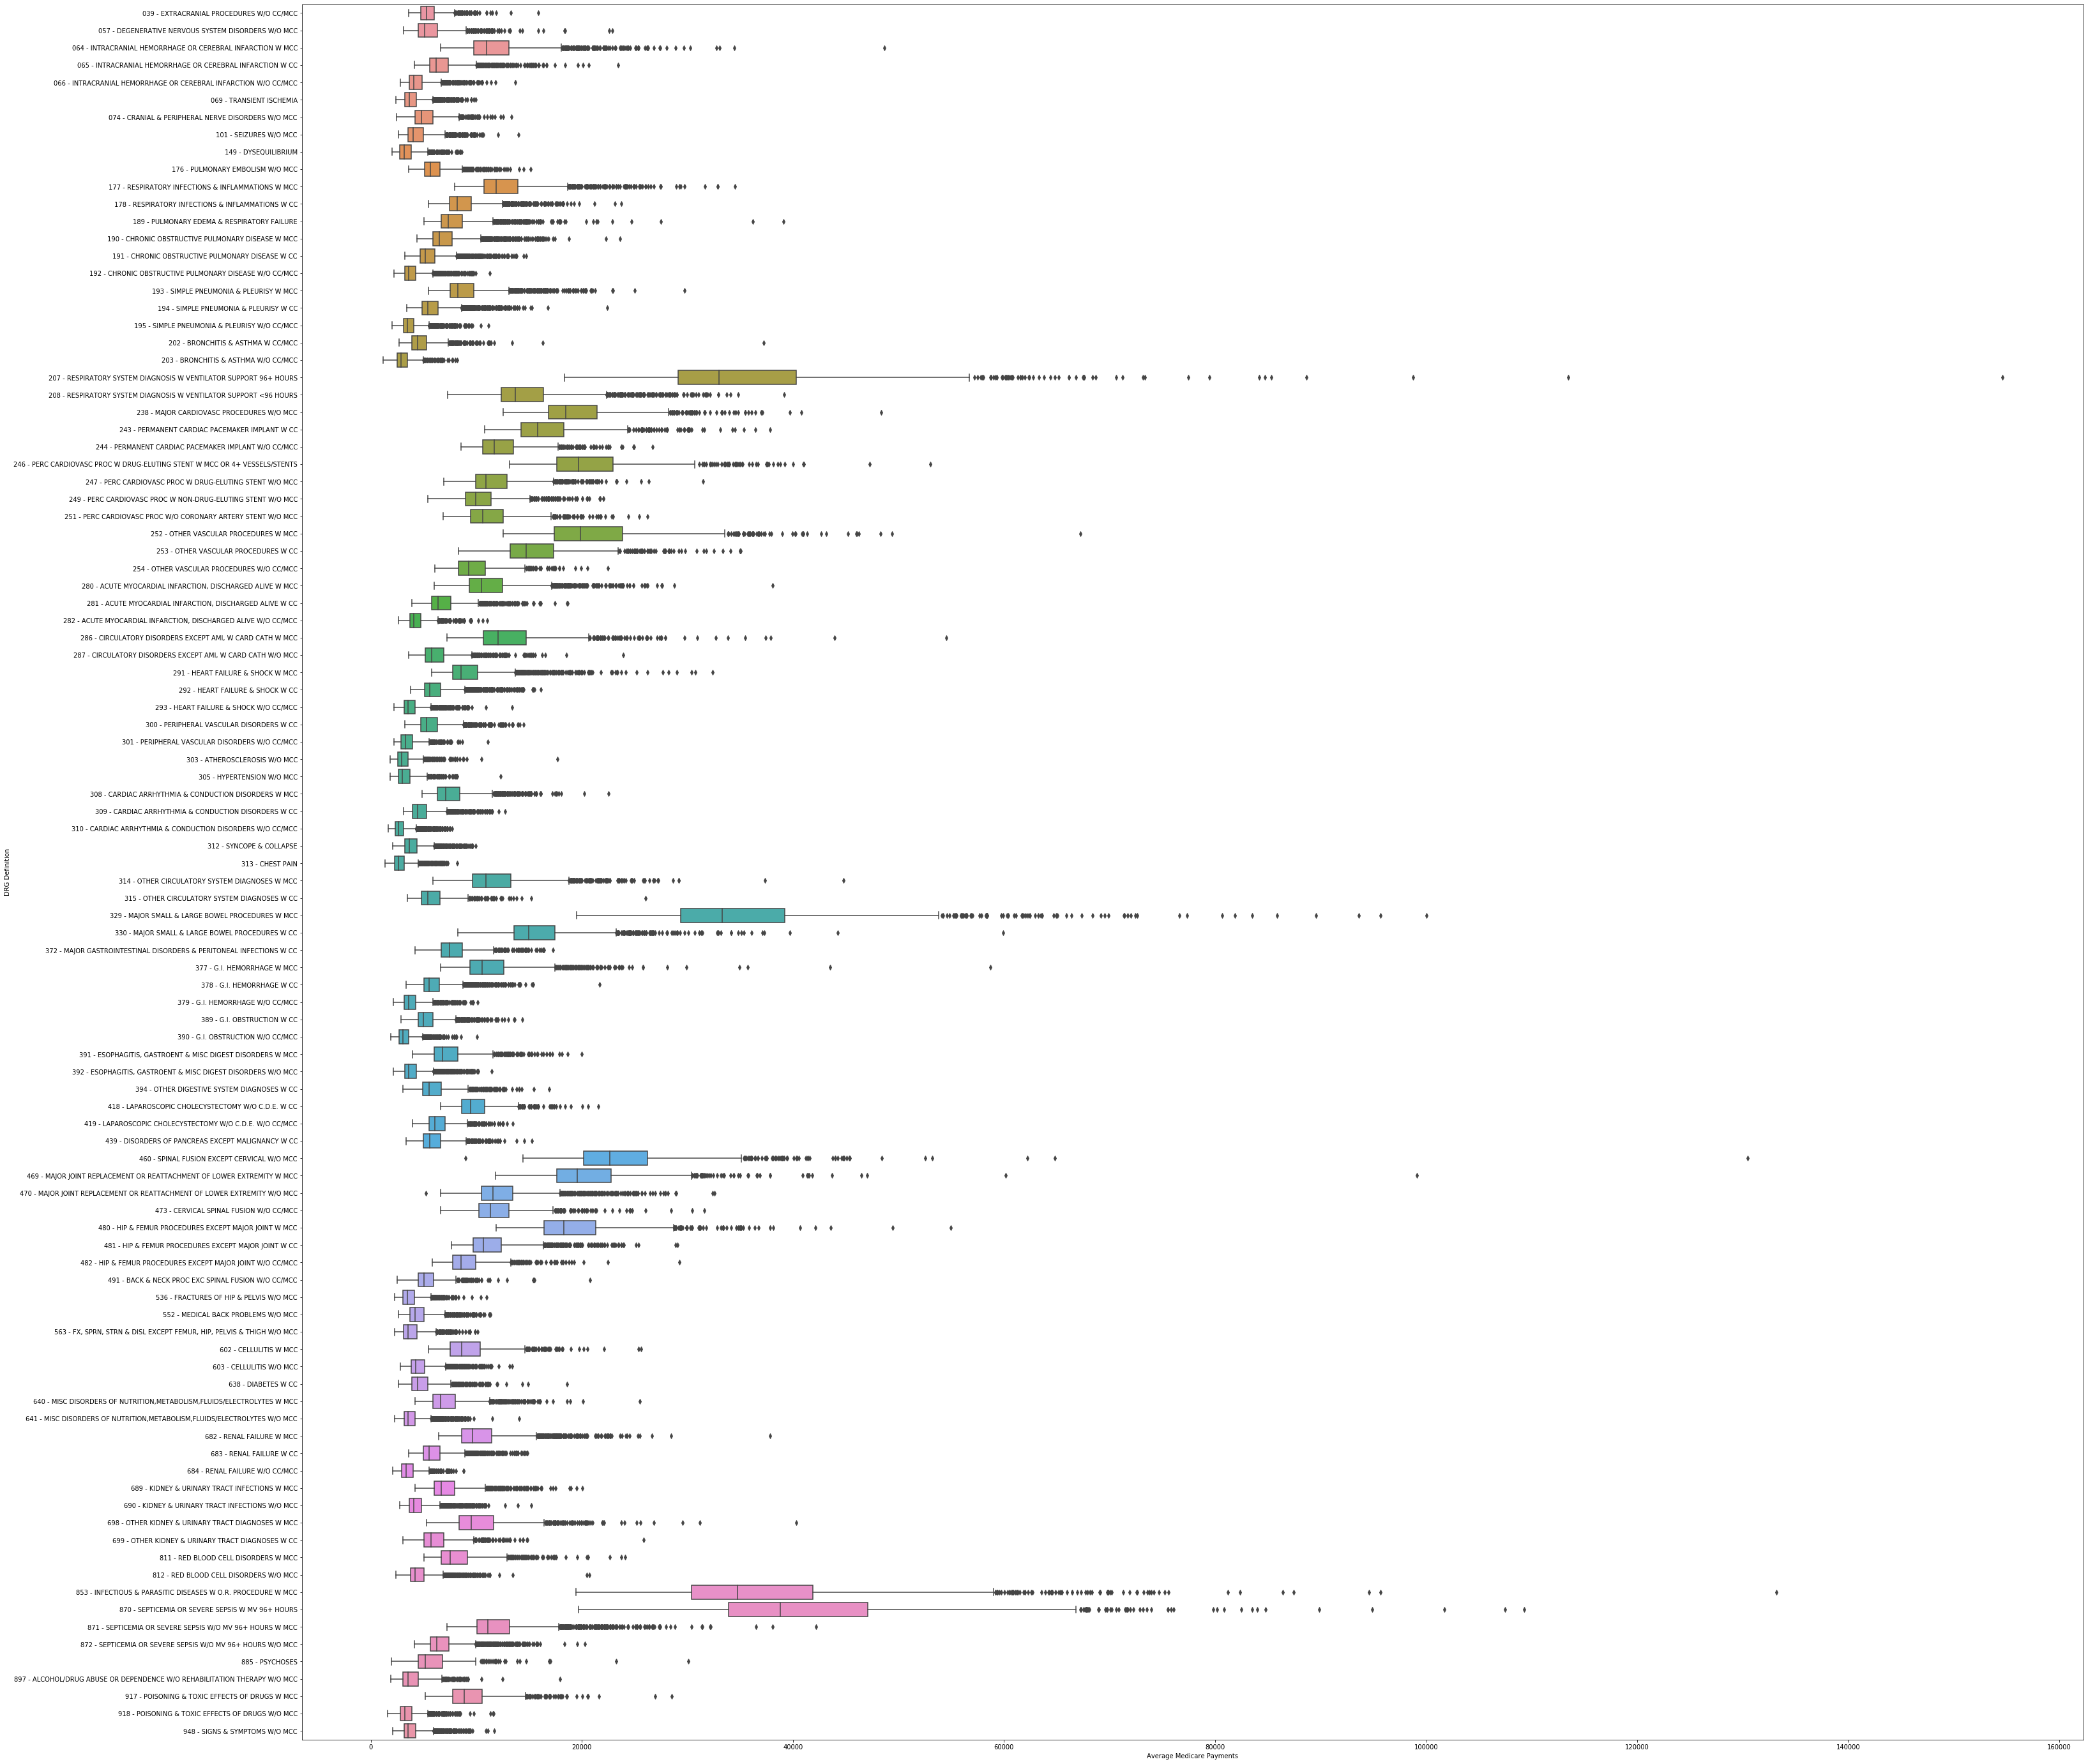

In [35]:
plt.figure(figsize=(50,50))
sns.boxplot(x=inpatient["Average Medicare Payments"],y=inpatient["DRG Definition"])

From a high viewpoint, we can definitely see the top 5 procedure we found does have the most variation in pricing as far as providers are concerned.<br>

>Top 5 Procedures with highest variation:
    1. 207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS
    2. 460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC
    3. 853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC
    4. 870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS
    5. 469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT OF LOWER EXTREMITY W MCC
    
>Top Providers with highest variation:
    1. Stanford Hospital
    2. Pinnacle Hospital
    3. Westchester Medical
    4. Milton Hershey Medical Centre

**Now for Outpatients**

In [149]:
# Checking if we have multiple entries for a provider and Procedure
(outpatient.groupby(["APC","Provider Id"])["Average Total Payments"].count()>1).unique()

array([False])

In [170]:
max_d = outpatient.groupby(["APC"])["Average Total Payments"].max().reset_index()
max_d.rename(columns={"Average Total Payments":"max_med_pay"},inplace=True)
min_d = outpatient.groupby(["APC"])["Average Total Payments"].min().reset_index()
min_d.rename(columns={"Average Total Payments":"min_med_pay"},inplace=True)

In [151]:
print(max_d.shape)
print(min_d.shape)

(30, 2)
(30, 2)


In [152]:
apc = pd.merge(max_d,min_d,on=["APC"],how='inner')
apc

,APC,max_med_pay,min_med_pay
0,0012 - Level I Debridement & Destruction,36.623853,7.305000
1,0013 - Level II Debridement & Destruction,85.930000,23.267308
2,0015 - Level III Debridement & Destruction,142.186505,36.415769
3,0019 - Level I Excision/ Biopsy,470.720000,204.989200
4,0020 - Level II Excision/ Biopsy,808.850000,271.806923
5,0073 - Level III Endoscopy Upper Airway,398.899204,223.364546
6,0074 - Level IV Endoscopy Upper Airway,2062.470526,884.101968
7,0078 - Level III Pulmonary Treatment,136.370000,52.791923
8,0096 - Level II Noninvasive Physiologic Studies,147.230000,46.215758
9,0203 - Level IV Nerve Injections,1218.580000,610.278000


In [153]:
apc["variation"] = apc.max_med_pay - apc.min_med_pay
apc.head()

,APC,max_med_pay,min_med_pay,variation
0,0012 - Level I Debridement & Destruction,36.623853,7.305000,29.318853
1,0013 - Level II Debridement & Destruction,85.930000,23.267308,62.662692
2,0015 - Level III Debridement & Destruction,142.186505,36.415769,105.770735
3,0019 - Level I Excision/ Biopsy,470.720000,204.989200,265.730800
4,0020 - Level II Excision/ Biopsy,808.850000,271.806923,537.043077


In [154]:
# We will concentrate on the first five procedures with the highest variance
apc = apc.sort_values(['variation'], ascending=[0])
apc.head()

,APC,max_med_pay,min_med_pay,variation
6,0074 - Level IV Endoscopy Upper Airway,2062.470526,884.101968,1178.368558
13,"0209 - Level II Extended EEG, Sleep, and Cardi...",1072.982991,388.657500,684.325491
9,0203 - Level IV Nerve Injections,1218.580000,610.278000,608.302000
21,0377 - Level II Cardiac Imaging,1050.740000,488.772308,561.967692
4,0020 - Level II Excision/ Biopsy,808.850000,271.806923,537.043077


In [191]:
top_apc = apc["APC"].head().to_list()
top_apc

['0074 - Level IV Endoscopy Upper Airway',
 '0209 - Level II Extended EEG, Sleep, and Cardiovascular Studies',
 '0203 - Level IV Nerve Injections',
 '0377 - Level II Cardiac Imaging',
 '0020 - Level II Excision/ Biopsy']

In [173]:
subset_o = outpatient[outpatient["APC"].isin(top_apc)].copy()
subset_o = pd.merge(subset_o,apc,on=["APC"],how='left')
subset_o

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,max_med_pay,min_med_pay,variation
0,0020 - Level II Excision/ Biopsy,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,38,4123.556579,527.290000,808.85,271.806923,537.043077
1,0020 - Level II Excision/ Biopsy,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,35,2058.910571,537.810000,808.85,271.806923,537.043077
2,0020 - Level II Excision/ Biopsy,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,23,4421.726522,485.220000,808.85,271.806923,537.043077
3,0020 - Level II Excision/ Biopsy,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,79,2317.746835,477.765823,808.85,271.806923,537.043077
4,0020 - Level II Excision/ Biopsy,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,73,1804.842740,514.850548,808.85,271.806923,537.043077
5,0020 - Level II Excision/ Biopsy,10024,JACKSON HOSPITAL & CLINIC INC,1725 PINE STREET,MONTGOMERY,AL,36106,AL - Montgomery,38,17970.861840,457.641316,808.85,271.806923,537.043077
6,0020 - Level II Excision/ Biopsy,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,24,2738.022083,534.670000,808.85,271.806923,537.043077
7,0020 - Level II Excision/ Biopsy,10033,UNIVERSITY OF ALABAMA HOSPITAL,619 SOUTH 19TH STREET,BIRMINGHAM,AL,35233,AL - Birmingham,15,8097.322667,535.370000,808.85,271.806923,537.043077
8,0020 - Level II Excision/ Biopsy,10038,STRINGFELLOW MEMORIAL HOSPITAL,301 EAST 18TH ST,ANNISTON,AL,36201,AL - Birmingham,13,6417.183077,509.990000,808.85,271.806923,537.043077
9,0020 - Level II Excision/ Biopsy,10039,HUNTSVILLE HOSPITAL,101 SIVLEY RD,HUNTSVILLE,AL,35801,AL - Huntsville,28,4577.230000,538.731429,808.85,271.806923,537.043077


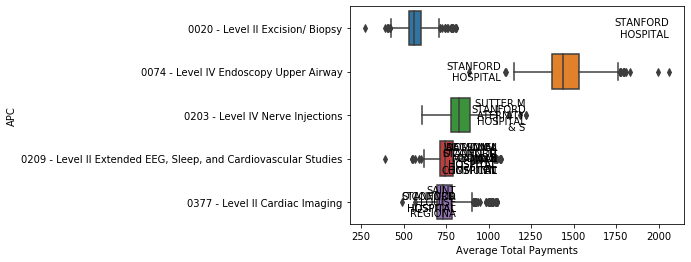

<Figure size 5040x3600 with 0 Axes>

In [179]:
boxplot = sns.boxplot(x=subset_o["Average Total Payments"],y=subset_o["APC"])

for row in subset_o.itertuples():
    provider = row[3][:20]
    proc = row[1]
    #top_apc = {i:top_apc[i]for i in range(0,len(top_apc))}
    for x in top_apc.items():
        if x[1] ==proc:
            y_axis = x[0]
    val = row[11]
    # Check if payment is the max for the procedure, then print the label
    if val == row[12]:
        plt.text(val, y_axis, textwrap.fill(provider,8), ha='right', va='center')

plt.figure(figsize=(70,50))
plt.show()

In [187]:
# To get better clarity on the providers with highest variations
q1 = outpatient.groupby(["APC"]).quantile(0.25)["Average Total Payments"].reset_index()
q1.rename(columns={"Average Total Payments":"lower_qrtl"},inplace=True)

q3 = outpatient.groupby(["APC"]).quantile(0.75)["Average Total Payments"].reset_index()
q3.rename(columns={"Average Total Payments":"upper_qrtl"},inplace=True)

outpatient = pd.merge(outpatient,q1,on=["APC"],how="left")
outpatient = pd.merge(outpatient,q3,on=["APC"],how="left")

outpatient["outlier_top_lim"] = outpatient["upper_qrtl"] + 1.5 * (outpatient["upper_qrtl"] - outpatient["lower_qrtl"])
outpatient.head()

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,lower_qrtl,upper_qrtl,outlier_top_lim
0,0012 - Level I Debridement & Destruction,10029,EAST ALABAMA MEDICAL CENTER AND SNF,2000 PEPPERELL PARKWAY,OPELIKA,AL,36801,AL - Birmingham,23,78.086957,21.910435,14.646094,19.577509,26.974632
1,0012 - Level I Debridement & Destruction,20024,CENTRAL PENINSULA GENERAL HOSPITAL,250 HOSPITAL PLACE,SOLDOTNA,AK,99669,AK - Anchorage,994,149.589749,36.623853,14.646094,19.577509,26.974632
2,0012 - Level I Debridement & Destruction,30064,"UNIVERSITY OF ARIZONA MEDICAL CTR-UNIVERSIT, THE",1501 NORTH CAMPBELL AVENUE,TUCSON,AZ,85724,AZ - Tucson,1765,50.135411,14.541841,14.646094,19.577509,26.974632
3,0012 - Level I Debridement & Destruction,30088,BANNER BAYWOOD MEDICAL CENTER,6644 EAST BAYWOOD AVENUE,MESA,AZ,85206,AZ - Mesa,20,112.400000,23.736000,14.646094,19.577509,26.974632
4,0012 - Level I Debridement & Destruction,30111,"UNIVERSITY OF ARIZONA MEDICAL CTR- SOUTH CAM, THE",2800 EAST AJO WAY,TUCSON,AZ,85713,AZ - Tucson,22,152.045455,16.569091,14.646094,19.577509,26.974632


In [194]:
sort_df = outpatient[outpatient["Average Total Payments"]>outpatient["outlier_top_lim"]][["APC","Provider Name","Average Total Payments","outlier_top_lim"]]
sort_df = sort_df[sort_df["APC"].isin(top_apc)].copy()

sort_df = sort_df.sort_values(['APC','Average Total Payments'], ascending=[1,0])
sort_df.to_excel("analysis_result/outpatient_overcharging_providers.xlsx")

For Outpatient Care, below are the top providers with highest cost variation on the procedure:
1. **0020 - Level II Excision/ Biopsy**
     - O'CONNOR HOSPITAL
     - STANFORD HOSPITAL
     - SAINT LOUISE REGIONAL HOSPITAL
2. **0074 - Level IV Endoscopy Upper Airway**
     - STANFORD HOSPITAL : Charged almost 17% more than the Upper limit of inter quartile range
3. **0203 - Level IV Nerve Injections**
     - STANFORD HOSPITAL
     - SUTTER MATERNITY & SURGERY CENTER OF SANTA CRUZ
4. **0209 - Level II Extended EEG, Sleep, and Cardiovascular Studies**
     - STANFORD HOSPITAL
5. **0377 - Level II Cardiac Imaging**
     - REGIONAL MEDICAL CENTER OF SAN JOSE
     - O'CONNOR HOSPITAL
     - WATSONVILLE COMMUNITY HOSPITAL
     - DOMINICAN HOSPITAL
     - EL CAMINO HOSPITAL
     - STANFORD HOSPITAL
<br><br>
***Stanford Hospital*** is making money hands over fist from the Medicare


### Part 1: A & C:- Highest Cost Variation for a Procedure by Region
**For Inpatient**

In [204]:
region = inpatient.groupby(["DRG Definition","Provider State"])["Average Medicare Payments"].mean().reset_index()
region.rename(columns={"Average Medicare Payments":"reg_avg_medicare_payout"},inplace=True)
region.head()

,DRG Definition,Provider State,reg_avg_medicare_payout
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AK,6413.782609
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AL,4599.596881
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AR,4938.716691
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,AZ,5912.837259
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,CA,6878.958616


In [205]:
max_r = region.groupby(["DRG Definition"])["reg_avg_medicare_payout"].max().reset_index()
max_r.rename(columns={"reg_avg_medicare_payout":"max_med_pay"},inplace=True)
min_r = region.groupby(["DRG Definition"])["reg_avg_medicare_payout"].min().reset_index()
min_r.rename(columns={"reg_avg_medicare_payout":"min_med_pay"},inplace=True)

In [206]:
print(max_r.shape)
print(min_r.shape)

(100, 2)
(100, 2)


In [199]:
proc_reg = pd.merge(max_r,min_r,on=["DRG Definition"],how='inner')
proc_reg

,DRG Definition,max_med_pay,min_med_pay
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,8110.820346,4599.596881
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,9146.607143,4280.838470
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,20555.263370,9570.976051
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,11140.966651,5430.878502
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8258.430631,3493.934936
5,069 - TRANSIENT ISCHEMIA,6904.859650,3096.146538
6,074 - CRANIAL & PERIPHERAL NERVE DISORDERS W/O...,8195.461538,3988.832847
7,101 - SEIZURES W/O MCC,6696.276615,3400.948522
8,149 - DYSEQUILIBRIUM,5036.469551,2439.133333
9,176 - PULMONARY EMBOLISM W/O MCC,8629.624732,4988.835380


In [200]:
proc_reg["variation"] = proc_reg.max_med_pay - proc_reg.min_med_pay
proc_reg.head()

,DRG Definition,max_med_pay,min_med_pay,variation
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,8110.820346,4599.596881,3511.223465
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,9146.607143,4280.838470,4865.768673
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,20555.263370,9570.976051,10984.287319
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,11140.966651,5430.878502,5710.088149
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,8258.430631,3493.934936,4764.495695


In [201]:
# We will concentrate on the first five procedures with the highest variance
proc_reg = proc_reg.sort_values(['variation'], ascending=[0])
proc_reg.head()

,DRG Definition,max_med_pay,min_med_pay,variation
52,329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,63646.051840,29370.016497,34276.035343
91,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,62017.317095,29288.299273,32729.017822
21,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,53626.062500,29106.882726,24519.179774
92,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,54308.152903,32688.534906,21619.617997
66,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,36131.776306,19256.400737,16875.375569


In [203]:
top_proc_reg = proc_reg["DRG Definition"].head().to_list()
top_proc_reg

['329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC',
 '853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC',
 '207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS',
 '870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS',
 '460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC']

In [209]:
sub_in = inpatient[inpatient["DRG Definition"].isin(top_proc_reg)].copy()
sub_in = pd.merge(sub_in,region,on=["DRG Definition","Provider State"],how='left')
sub_in = pd.merge(sub_in,proc_reg,on=["DRG Definition"],how='left')
sub_in.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments,reg_avg_medicare_payout,max_med_pay,min_med_pay,variation
0,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,19,107347.5263,28246.68421,27831.31579,29488.425082,53626.0625,29106.882726,24519.179774
1,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,12,117772.9167,27573.41667,26638.08333,29488.425082,53626.0625,29106.882726,24519.179774
2,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,15,121698.5333,35806.53333,29393.46667,29488.425082,53626.0625,29106.882726,24519.179774
3,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,21,117604.2381,34607.95238,32496.47619,29488.425082,53626.0625,29106.882726,24519.179774
4,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,10024,JACKSON HOSPITAL & CLINIC INC,1725 PINE STREET,MONTGOMERY,AL,36106,AL - Montgomery,19,89957.0000,27953.78947,27180.94737,29488.425082,53626.0625,29106.882726,24519.179774


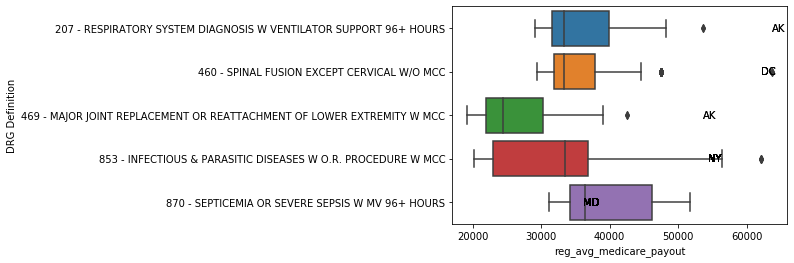

In [210]:
boxplot = sns.boxplot(x=sub_in["reg_avg_medicare_payout"],y=subset["DRG Definition"])

for row in sub_in.itertuples():
    regn = row[6]
    proc = row[1]
    top_proc_reg_dct = {i:top_proc_reg[i]for i in range(0,len(top_proc_reg))}
    for x in top_proc_reg_dct.items():
        if x[1] ==proc:
            y_axis = x[0]
    val = row[13]
    # Check if payment is the max for the procedure, then print the label
    if val == row[14]:
        plt.text(val, y_axis, regn, ha='left', va='center')

plt.show()

>Top 5 Procedures with highest variation per region:
    1. 329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC
    2. 853 - INFECTIOUS & PARASITIC DISEASES W O.R. PROCEDURE W MCC
    3. 207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS
    4. 870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS
    5. 460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC'
    
>Top Regions with highest variation:
    1. AK - Alaska
    2. DC - District of Columbia (Washington)
    3. NY - New York
    4. MD - Maryland



Alaska could be expensive due to the remote nature of the area. Getting certain procedures maybe more expensive than the mainland. All the others are metropolitan and high cost of living areas.

**Now for Outpatients**

In [211]:
region_out = outpatient.groupby(["APC","Provider State"])["Average Total Payments"].mean().reset_index()
region_out.rename(columns={"Average Total Payments":"reg_avg_total_payout"},inplace=True)
region_out.head()

,APC,Provider State,reg_avg_total_payout
0,0012 - Level I Debridement & Destruction,AK,36.623853
1,0012 - Level I Debridement & Destruction,AL,21.910435
2,0012 - Level I Debridement & Destruction,AR,18.547341
3,0012 - Level I Debridement & Destruction,AZ,18.282311
4,0012 - Level I Debridement & Destruction,CA,21.010814


In [212]:
max_r = region_out.groupby(["APC"])["reg_avg_total_payout"].max().reset_index()
max_r.rename(columns={"reg_avg_total_payout":"max_med_pay"},inplace=True)
min_r = region_out.groupby(["APC"])["reg_avg_total_payout"].min().reset_index()
min_r.rename(columns={"reg_avg_total_payout":"min_med_pay"},inplace=True)

In [213]:
print(max_r.shape)
print(min_r.shape)

(30, 2)
(30, 2)


In [214]:
proc_reg = pd.merge(max_r,min_r,on=["APC"],how='inner')
proc_reg

,APC,max_med_pay,min_med_pay
0,0012 - Level I Debridement & Destruction,36.623853,13.350000
1,0013 - Level II Debridement & Destruction,72.655128,45.964286
2,0015 - Level III Debridement & Destruction,119.171080,87.041089
3,0019 - Level I Excision/ Biopsy,416.007801,304.470274
4,0020 - Level II Excision/ Biopsy,676.861912,493.888582
5,0073 - Level III Endoscopy Upper Airway,345.510000,240.928344
6,0074 - Level IV Endoscopy Upper Airway,1698.250551,1251.623333
7,0078 - Level III Pulmonary Treatment,116.982134,86.037025
8,0096 - Level II Noninvasive Physiologic Studies,122.624158,91.803887
9,0203 - Level IV Nerve Injections,1074.810778,610.278000


In [215]:
proc_reg["variation"] = proc_reg.max_med_pay - proc_reg.min_med_pay
proc_reg.head()

,APC,max_med_pay,min_med_pay,variation
0,0012 - Level I Debridement & Destruction,36.623853,13.350000,23.273853
1,0013 - Level II Debridement & Destruction,72.655128,45.964286,26.690842
2,0015 - Level III Debridement & Destruction,119.171080,87.041089,32.129991
3,0019 - Level I Excision/ Biopsy,416.007801,304.470274,111.537528
4,0020 - Level II Excision/ Biopsy,676.861912,493.888582,182.973329


In [216]:
# We will concentrate on the first five procedures with the highest variance
proc_reg = proc_reg.sort_values(['variation'], ascending=[0])
proc_reg.head()

,APC,max_med_pay,min_med_pay,variation
9,0203 - Level IV Nerve Injections,1074.810778,610.278000,464.532778
6,0074 - Level IV Endoscopy Upper Airway,1698.250551,1251.623333,446.627218
21,0377 - Level II Cardiac Imaging,893.110126,665.226360,227.883766
13,"0209 - Level II Extended EEG, Sleep, and Cardi...",912.798529,685.175901,227.622629
4,0020 - Level II Excision/ Biopsy,676.861912,493.888582,182.973329


In [217]:
top_apc_reg = proc_reg["APC"].head().to_list()
top_apc_reg

['0203 - Level IV Nerve Injections',
 '0074 - Level IV Endoscopy Upper Airway',
 '0377 - Level II Cardiac Imaging',
 '0209 - Level II Extended EEG, Sleep, and Cardiovascular Studies',
 '0020 - Level II Excision/ Biopsy']

In [218]:
sub_out = outpatient[outpatient["APC"].isin(top_apc_reg)].copy()
sub_out = pd.merge(sub_out,region_out,on=["APC","Provider State"],how='left')
sub_out = pd.merge(sub_out,proc_reg,on=["APC"],how='left')
sub_out.head()

,APC,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,lower_qrtl,upper_qrtl,outlier_top_lim,reg_avg_total_payout,max_med_pay,min_med_pay,variation
0,0020 - Level II Excision/ Biopsy,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,38,4123.556579,527.290000,530.092567,602.197132,710.353981,493.888582,676.861912,493.888582,182.973329
1,0020 - Level II Excision/ Biopsy,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,35,2058.910571,537.810000,530.092567,602.197132,710.353981,493.888582,676.861912,493.888582,182.973329
2,0020 - Level II Excision/ Biopsy,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,23,4421.726522,485.220000,530.092567,602.197132,710.353981,493.888582,676.861912,493.888582,182.973329
3,0020 - Level II Excision/ Biopsy,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,79,2317.746835,477.765823,530.092567,602.197132,710.353981,493.888582,676.861912,493.888582,182.973329
4,0020 - Level II Excision/ Biopsy,10023,BAPTIST MEDICAL CENTER SOUTH,2105 EAST SOUTH BOULEVARD,MONTGOMERY,AL,36116,AL - Montgomery,73,1804.842740,514.850548,530.092567,602.197132,710.353981,493.888582,676.861912,493.888582,182.973329


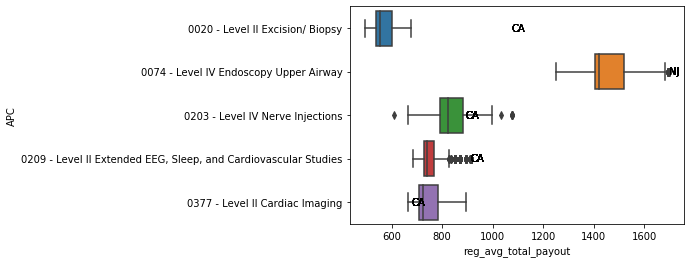

In [221]:
boxplot = sns.boxplot(x=sub_out["reg_avg_total_payout"],y=sub_out["APC"])

for row in sub_out.itertuples():
    regn = row[6]
    proc = row[1]
    top_apc_reg_dct = {i:top_apc_reg[i]for i in range(0,len(top_apc_reg))}
    for x in top_apc_reg_dct.items():
        if x[1] ==proc:
            y_axis = x[0]
    val = row[15]
    # Check if payment is the max for the procedure, then print the label
    if val == row[16]:
        plt.text(val, y_axis, regn, ha='left', va='center')

plt.show()

Top Procedures with highest variation(by Region) for outpatients:
1. 0203 - Level IV Nerve Injections
2. 0074 - Level IV Endoscopy Upper Airway
3. 0377 - Level II Cardiac Imaging
4. 0209 - Level II Extended EEG, Sleep, and Cardiovascular Studies
5. 0020 - Level II Excision/ Biopsy
<br><br>
**California** is the most expensive state for most of these procedures, but **New Jersey** stands out for Upper Airway Endoscopy.

### Part 1: D:- Highest Number of Procedures and Largest Differences between Claims and Reimbursements - Providers
**For Inpatients**

In [309]:
claim_in = inpatient.groupby(["Provider Id","Provider Name","Provider State"]).agg({"Total Discharges":'sum',
                                                                                   "Average Covered Charges":'mean',
                                                                                   "Average Total Payments":'mean'})
claim_in.head()

,,,Total Discharges,Average Covered Charges,Average Total Payments
Provider Id,Provider Name,Provider State,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,5405,35247.032779,8749.029587
10005,MARSHALL MEDICAL CENTER SOUTH,AL,1419,16451.095600,6812.135550
10006,ELIZA COFFEE MEMORIAL HOSPITAL,AL,3901,36942.362289,8197.242449
10007,MIZELL MEMORIAL HOSPITAL,AL,603,12079.540804,4860.834035
10008,CRENSHAW COMMUNITY HOSPITAL,AL,161,16148.757491,5898.141656


In [310]:
claim_in["Payout_Diff"] = claim_in["Average Covered Charges"]-claim_in["Average Total Payments"]
claim_in.head()

,,,Total Discharges,Average Covered Charges,Average Total Payments,Payout_Diff
Provider Id,Provider Name,Provider State,,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,5405,35247.032779,8749.029587,26498.003192
10005,MARSHALL MEDICAL CENTER SOUTH,AL,1419,16451.095600,6812.135550,9638.960051
10006,ELIZA COFFEE MEMORIAL HOSPITAL,AL,3901,36942.362289,8197.242449,28745.119840
10007,MIZELL MEMORIAL HOSPITAL,AL,603,12079.540804,4860.834035,7218.706769
10008,CRENSHAW COMMUNITY HOSPITAL,AL,161,16148.757491,5898.141656,10250.615836


In [311]:
# Checking if there are any transactions where the payout is more than what has been claimed by the provider
claim_in[claim_in["Payout_Diff"]<0].sort_values(by=["Payout_Diff"],ascending=1)

,,,Total Discharges,Average Covered Charges,Average Total Payments,Payout_Diff
Provider Id,Provider Name,Provider State,,,,
320067,GUADALUPE COUNTY HOSPITAL,NM,25,4918.948052,12006.889610,-7087.941558
60043,KEEFE MEMORIAL HOSPITAL,CO,19,10363.842110,15172.000000,-4808.157890
330080,LINCOLN MEDICAL & MENTAL HEALTH CENTER,NY,1509,12421.772917,16812.911018,-4391.138101
330009,BRONX-LEBANON HOSPITAL CENTER,NY,1734,16085.768041,18857.258452,-2771.490411
20018,YUKON KUSKOKWIM DELTA REG HOSPITAL,AK,137,7646.026431,9939.557077,-2293.530645
250079,SHARKEY ISSAQUENA COMMUNITY HOSPITAL,MS,30,3369.961723,5650.342105,-2280.380383
320060,ZUNI COMPREHENSIVE COMMUNITY HEALTH CENTER,NM,16,7385.250000,9500.750000,-2115.500000
510086,WELCH COMMUNITY HOSPITAL,WV,90,7978.862645,9874.266233,-1895.403588
250051,KILMICHAEL HOSPITAL,MS,45,4537.815385,6213.851885,-1676.036501


These cases would be interesting to explore further as payments more than the claim could be an indication of fraudulent activity

In [312]:
claim_in["Pct_Total_Procedures"] = claim_in["Total Discharges"]/claim_in["Total Discharges"].sum()*100
claim_in["Pct_Payout_Diff"] = claim_in["Payout_Diff"]/claim_in["Payout_Diff"].sum()*100
claim_in.sort_values(by=["Payout_Diff"],ascending=0)

,,,Total Discharges,Average Covered Charges,Average Total Payments,Payout_Diff,Pct_Total_Procedures,Pct_Payout_Diff
Provider Id,Provider Name,Provider State,,,,,,
490142,UVA HEALTH SCIENCES CENTER,VA,18,211922.000000,50552.611110,161369.388890,0.000258,0.212897
310025,BAYONNE HOSPITAL CENTER,NJ,1865,147441.337388,10012.708490,137428.628899,0.026737,0.181312
50464,DOCTORS MEDICAL CENTER,CA,2114,144695.837072,14672.491970,130023.345102,0.030307,0.171542
390180,CROZER CHESTER MEDICAL CENTER,PA,4957,137130.851966,11694.688539,125436.163427,0.071065,0.165490
50367,NORTHBAY MEDICAL CENTER,CA,1767,138504.549580,16563.358469,121941.191111,0.025332,0.160879
50195,WASHINGTON HOSPITAL,CA,3444,131510.126440,16444.265666,115065.860774,0.049374,0.151808
50441,STANFORD HOSPITAL,CA,3821,138818.653932,24354.788533,114463.865399,0.054779,0.151014
50289,SETON MEDICAL CENTER,CA,1739,130177.366167,17681.773622,112495.592545,0.024931,0.148417
50680,NORTHBAY VACAVALLEY HOSPITAL,CA,38,122472.354987,11478.849485,110993.505502,0.000545,0.146436


In [320]:
claim_in.sort_values(by=["Pct_Total_Procedures"],ascending=0)

,,,Total Discharges,Average Covered Charges,Average Total Payments,Payout_Diff,Pct_Total_Procedures,Pct_Payout_Diff
Provider Id,Provider Name,Provider State,,,,,,
100007,FLORIDA HOSPITAL,FL,25828,51151.349466,10499.179115,40652.170351,0.370277,0.053633
330101,NEW YORK-PRESBYTERIAN HOSPITAL,NY,16834,50675.606443,18170.687897,32504.918547,0.241337,0.042884
450388,METHODIST HOSPITAL,TX,15921,46154.822457,9858.733780,36296.088677,0.228248,0.047886
80001,"CHRISTIANA CARE HEALTH SERVICES, INC.",DE,14542,26564.133158,11910.664728,14653.468431,0.208478,0.019333
230130,WILLIAM BEAUMONT HOSPITAL,MI,14469,32116.308611,11332.709475,20783.599135,0.207431,0.027420
220074,"SOUTHCOAST HOSPITAL GROUP, INC",MA,14202,23670.337227,10972.452621,12697.884606,0.203604,0.016753
440049,METHODIST HEALTHCARE MEMPHIS HOSPITALS,TN,13736,38665.345692,11687.002804,26978.342888,0.196923,0.035593
330059,MONTEFIORE MEDICAL CENTER,NY,12204,56119.343118,18150.910993,37968.432125,0.174960,0.050092
180088,"NORTON HOSPITALS, INC",KY,11856,37381.498195,10082.178248,27299.319947,0.169971,0.036016


The provider with the highest difference between Claims and Reimbursement is **UVA Health Science Centre, VA**. This is for one procedure - **RESPIRATORY SYSTEM DIAGNOSIS W VENTILATOR SUPPORT 96+ HOURS**, which has also featured in our analysis of highest cost variation for a procedure.
<br>
<br>
And the Provider doling out the most procedures is **Florida Hospital,FL**. Sometimes stereotypes are there for a reason!
<br><br>
**Now for Outpatients**

In [321]:
claim_out = outpatient.groupby(["Provider Id","Provider Name","Provider State"]).agg({"Outpatient Services":'sum',
                                                                                   "Average  Estimated Submitted Charges":'mean',
                                                                                   "Average Total Payments":'mean'})
claim_out.head()

,,,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments
Provider Id,Provider Name,Provider State,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,17856,1942.914036,285.699426
10005,MARSHALL MEDICAL CENTER SOUTH,AL,4252,903.855812,254.564837
10006,ELIZA COFFEE MEMORIAL HOSPITAL,AL,4991,1086.896047,221.871666
10007,MIZELL MEMORIAL HOSPITAL,AL,616,1033.919037,251.371890
10008,CRENSHAW COMMUNITY HOSPITAL,AL,259,1070.159851,207.481575


In [322]:
claim_out["Payout_Diff"] = claim_out["Average  Estimated Submitted Charges"]-claim_out["Average Total Payments"]
claim_out.head()

,,,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,Payout_Diff
Provider Id,Provider Name,Provider State,,,,
10001,SOUTHEAST ALABAMA MEDICAL CENTER,AL,17856,1942.914036,285.699426,1657.214610
10005,MARSHALL MEDICAL CENTER SOUTH,AL,4252,903.855812,254.564837,649.290975
10006,ELIZA COFFEE MEMORIAL HOSPITAL,AL,4991,1086.896047,221.871666,865.024381
10007,MIZELL MEMORIAL HOSPITAL,AL,616,1033.919037,251.371890,782.547148
10008,CRENSHAW COMMUNITY HOSPITAL,AL,259,1070.159851,207.481575,862.678277


In [323]:
# Checking if there are any transactions where the payout is more than what has been claimed by the provider
claim_out[claim_out["Payout_Diff"]<0].sort_values(by=["Payout_Diff"],ascending=1)

,,,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,Payout_Diff
Provider Id,Provider Name,Provider State,,,,


In [324]:
claim_out.sort_values(by=["Payout_Diff"],ascending=0)

,,,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,Payout_Diff
Provider Id,Provider Name,Provider State,,,,
50205,EAST VALLEY HOSPITAL MEDICAL CENTER,CA,15,10836.473330,585.830000,10250.643330
670029,FIRST STREET HOSPITAL LP,TX,13,9498.550769,419.676923,9078.873846
450683,RENAISSANCE HOSPITAL TERRELL,TX,36,7637.296667,492.354167,7144.942500
100223,FORT WALTON BEACH MEDICAL CENTER,FL,1367,7016.688532,340.535295,6676.153237
450774,TOPS SURGICAL SPECIALTY HOSPITAL,TX,299,7044.643980,508.125318,6536.518662
290046,SPRING VALLEY HOSPITAL MEDICAL CENTER,NV,516,6735.408347,460.662402,6274.745945
100243,BRANDON REGIONAL HOSPITAL,FL,622,5717.862895,438.411562,5279.451333
310118,MEADOWLANDS HOSPITAL MEDICAL CENTER,NJ,527,5669.137325,396.082924,5273.054401
670005,MEMORIAL HERMANN SURGICAL HOSPITAL KINGWOOD,TX,38,5568.564596,307.252407,5261.312189


In [325]:
claim_out.sort_values(by=["Outpatient Services"],ascending=0)

,,,Outpatient Services,Average Estimated Submitted Charges,Average Total Payments,Payout_Diff
Provider Id,Provider Name,Provider State,,,,
450054,SCOTT & WHITE MEMORIAL HOSPITAL,TX,395466,1212.254520,277.643195,934.611325
360180,CLEVELAND CLINIC,OH,369152,1569.881783,270.091157,1299.790626
220171,LAHEY CLINIC HOSPITAL,MA,255910,855.199814,301.812867,553.386947
140010,EVANSTON HOSPITAL,IL,219643,1057.425735,289.670980,767.754756
140276,LOYOLA UNIVERSITY MEDICAL CENTER,IL,186703,919.956425,276.889776,643.066649
220071,MASSACHUSETTS GENERAL HOSPITAL,MA,176943,1939.968485,345.886302,1594.082183
490009,UNIVERSITY OF VIRGINIA MEDICAL CENTER,VA,150962,994.675612,271.211505,723.464107
340030,DUKE UNIVERSITY HOSPITAL,NC,148659,1547.245590,275.290627,1271.954963
140088,THE UNIVERSITY OF CHICAGO MEDICAL CENTER,IL,148198,1396.069163,285.821446,1110.247717


The providers featuring in highest Claim vs Reimbursement are **EAST VALLEY HOSPITAL MEDICAL CENTER, CA** and **FIRST STREET HOSPITAL LP, TX**. Both for the ACP **Level III Nerve Injections**. They have the highest payout difference than their peers.
<br><br>
For the provider undertaking the maximum procedure is **SCOTT & WHITE MEMORIAL HOSPITAL, TX**, followed closely by **CLEVELAND CLINIC, OH**. These providers do not have significant payout differences.